# Identifying Entities in Healthcare Data

In [3]:
# install required packages
!pip install pycrf
!pip install sklearn-crfsuite

  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1871 sha256=d6ff7d866d5c7e768a789544b4929f459e1d6387b49039ebf112d224de86300c
  Stored in directory: /root/.cache/pip/wheels/fd/3a/fb/e4d15c9c2b169f43811b23a863ee9717ff3eda5d2301789043
Successfully built pycrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.5 MB/s eta 0:00:00


In [1]:
# import required libraries

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# loading spacy model
model = spacy.load("en_core_web_sm")

##Data Preprocessing


In [6]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# function to convert docs in sentences
def convert_to_sentences(file_name):
    file=open(file_name,'r')
    data=file.readlines()
    file.close()
    L=[];sent=[]
    for line in data:
        if line == '\n':
            sent.append(" ".join(L))
            L=[]
        else:
            L.append(line.rstrip('\n'))
    return sent

In [8]:
# top 5 senteces of training senteces dataset
train_sent =  convert_to_sentences('/content/drive/MyDrive/syntactic_processing_data/train_sent')
train_sent[0:5]

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )',
 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )',
 "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )",
 "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]

In [9]:
# top 5 senteces of training labels dataset
train_label =  convert_to_sentences('/content/drive/MyDrive/syntactic_processing_data/train_label')
train_label[0:5]

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O']

In [10]:
# top 5 senteces of training labels dataset
test_sent =  convert_to_sentences('/content/drive/MyDrive/syntactic_processing_data/test_sent')
test_sent[0:5]

['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )',
 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration',
 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period',
 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )',
 'Fluctuations in ambient temperature are inversely correlated to changes in AFI']

In [11]:
# top 5 senteces of training labels dataset
test_label =  convert_to_sentences('/content/drive/MyDrive/syntactic_processing_data/test_label')
test_label[0:5]

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O']

### Count the number of sentences in the processed train and test dataset

In [12]:
print("Number of sentences in train sentences dataset: ",len(train_sent))
print("Number of sentences in test sentences dataset: ",len(test_sent))

Number of sentences in train sentences dataset:  2599
Number of sentences in test sentences dataset:  1056


### Count the number of lines of labels in the processed train and test dataset.

In [13]:
print("Number of lines in train labels dataset: ",len(train_label))
print("Number of lines in test labels dataset: ",len(test_label))

Number of lines in train labels dataset:  2599
Number of lines in test labels dataset:  1056


## EDA

In [16]:
# Combining trains and test sentences for EDA
all_sent = train_sent+test_sent
len(all_sent)


3655

In [17]:
# Combining trains and test labels for EDA
all_labels=train_label+test_label
len(all_labels)

3655

In [20]:
# Creating a dataframe out of the given sentences and labels
df=pd.DataFrame(list(zip(all_sent,all_labels)), columns=['sentences','labels'])
df.head()

,sentences,labels
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O O O
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O


In [23]:
# Creating new columns which is the total number of O tags, D tags and T tags in a sentence/document

df['O_label']=df.labels.apply(lambda x: len(re.findall('O',x)))
df['D_label']=df.labels.apply(lambda x: len(re.findall('D',x)))
df['T_label']=df.labels.apply(lambda x: len(re.findall('T',x)))
df.head(10)

,sentences,labels,O_label,D_label,T_label
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...,45,0,0
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O O O,25,0,0
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O,15,0,0
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...,38,0,0
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O,22,0,0
5,Cesarean rates at tertiary care hospitals shou...,O O O O O O O O O O O O O O O O O O O O O O O O,24,0,0
6,"In the third trimester , the amniotic fluid in...",O O O O O O O O O O O O O O O O O O O,19,0,0
7,We hypothesize that as temperature increases t...,O O O O O O O O O O O O O O,14,0,0
8,"From June 11 to August 16 , 1993 , during a pe...",O O O O O O O O O O O O O O O O O O O O O O O ...,40,0,0
9,The daily high ambient temperature in our urba...,O O O O O O O O O O O O,12,0,0


In [24]:
df.shape

(3655, 5)

In [25]:
df.describe()

,O_label,D_label,T_label
count,3655.000000,3655.000000,3655.000000
mean,15.269494,1.337620,1.045417
std,12.396386,2.109442,2.377397
min,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000
50%,12.000000,0.000000,0.000000
75%,21.000000,2.000000,1.000000
max,125.000000,34.000000,30.000000


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3655 entries, 0 to 3654
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentences  3655 non-null   object
 1   labels     3655 non-null   object
 2   O_label    3655 non-null   int64 
 3   D_label    3655 non-null   int64 
 4   T_label    3655 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 142.9+ KB


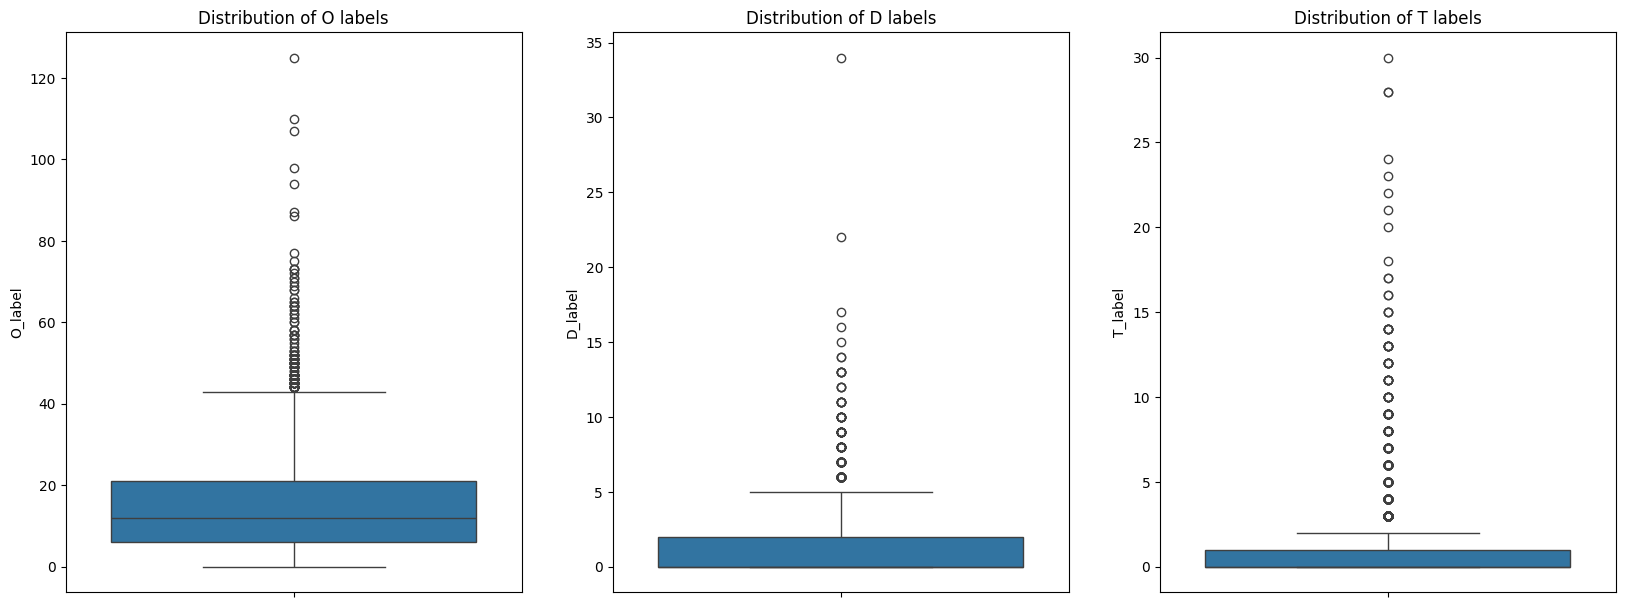

In [28]:
plt.figure(figsize=(20,16))
plt.subplot(2,3,1)
plt.title('Distribution of O labels')
sns.boxplot(df.O_label)
plt.subplot(2,3,2)
plt.title('Distribution of D labels')
sns.boxplot(df.D_label)
plt.subplot(2,3,3)
plt.title('Distribution of T labels')
sns.boxplot(df.T_label)
plt.show()

##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [30]:
# Identifying tokens with POS tag as NOUN and PRONOUN
noun_or_propn=[]
for sent in all_sent:
    doc=model(sent)
    for token in doc:
        if token.pos_=='NOUN' or token.pos_=='PROPN':
            noun_or_propn.append(token.lemma_.lower())

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [31]:
pd.Series(noun_or_propn).value_counts().head(25)

,count
patient,568
treatment,316
%,247
study,236
cancer,226
cell,203
therapy,182
effect,181
disease,170
group,145


## Defining features for CRF

####Computing Features using the following features for our input sequences.
#### We have defined the following features for CRF model building:
##### 1) If the word is at the beginning of sentence we mark it as 'BEG'
##### 2) If the word is at the end of the sentence we mark it as 'END'
##### 3) If the given word is not the beginning of the sentence, we include the features of the previous word too
##### 4)  f1=postag of the word
##### 5) f2=word in lower case
##### 6) f3=last 3 characters of the word
##### 7) f4=last 2 characters of the word
##### 8) f5=1; if the word is in uppercase, otherwise 0
##### 9) f6=1; if word is a number; otherwise 0
##### 10) f7=1; if the word starts with a capital letter, otherwise 0





In [32]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
  word=sentence[pos]
  for token in model(word):
    word_pos_tag=token.pos_
  features=[
    'word.postag='+word_pos_tag,
    'word.lower='+word.lower(),
    'word[-3:]='+word[-3:],
    'word[-2:]='+word[-2:],
    'word.isupper=%s' % word.isupper(),
    'word.isdigit=%s' % word.isdigit(),
    'words.startsWithCapital=%s' %word[0].isupper()
  ]
  if pos>0:
    prev_word=sentence[pos-1]
    for token in model(prev_word):
      prev_word_pos_tag=token.pos_
    features.extend([
      'prev_word.postag='+prev_word_pos_tag,
      'prev_word.lower=' + prev_word.lower(),
      'prev_word.isupper=%s' % prev_word.isupper(),
      'prev_word.isdigit=%s' % prev_word.isdigit(),
      'prev_words.startsWithCapital=%s' % prev_word[0].isupper()
    ])
  else:
    features.append('BEG')
  if (pos == len(sentence)-1):
    features.append('END')
  return features

## Getting the features

In [33]:
# code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

In [34]:
# code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [36]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label]

### Define the labels as the target variable for test and the train dataset

In [37]:
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]

## Build the CRF Model

In [38]:
# Build the CRF model.
crf=sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)


CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [39]:
Y_pred=crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [40]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9086027308076592

In [41]:
# Testing a sample prediction against actual values
# Print the orginal labels and predicted labels for the sentence  in test data, which is at index value 1001
id = 1001
print("Sentence:",test_sent[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

Sentence: An active-control trial of lamotrigine monotherapy for partial seizures
Orig Labels: ['O', 'O', 'O', 'O', 'T', 'T', 'O', 'D', 'D']
Pred Labels: ['O', 'O', 'O', 'O', 'T', 'T', 'O', 'D', 'D']


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



In [42]:
# Creating dictionary out of the predicted labels from our model
dict={}
for count, labels in enumerate(Y_pred): # we are taking the Y-pred labels and count will have the record ID
    temp="".join(labels) # removing the spaces between the lablels
    #print(count, temp)
    totalD=len(re.findall('D',temp)) # find number of 'D' in the sentence
    totalT=len(re.findall('T',temp)) # find number of 'T' in the sentence
    if totalD>0 and totalT>0: # this means that the sentence has disease and treatment
        indexD=[];indexT=[];start_from=0 # Initializing variables used
        for i in range(totalD):
            foundat=temp.find('D',start_from) # search for 'D' from start_from in the labels
            indexD.append(foundat) # put the foundat index in a list called indexD
            start_from=foundat+1 # re-initialize start_from from the next word
        start_from=0 # initialize the same variable for 'T' labels now
        for i in range(totalT):
            foundat=temp.find('T',start_from) # search for 'T' from start_from in the labels
            indexT.append(foundat) # put the foundat index in a list called indexT
            start_from=foundat+1 # re-initialize start_from from the next word
        disease='' # Initialize the string disease with empty string
        for i in indexD: # Looping through the indexes where 'D' is located
            disease=disease+test_sent[count].split()[i] # we are taking i-th word of the count which is index of sentence
            if i+1 not in indexD: # Check condition if the next word is also in the list
                disease=disease+', ' # this will be executed for a new disease
            else:
                disease=disease+' ' # this will be executed for continuation of disease name
        treatment='' # Initialize the string treatment with empty string
        for i in indexT: # Looping through the indexes where 'D' is located
            treatment=treatment+test_sent[count].split()[i] # we are taking i-th word of the count which is index of sentence
            if i+1 not in indexT: # Check condition if the next word is also in the list
                treatment=treatment+', ' # this will be executed for a new treatment
            else:
                treatment=treatment+' ' # this will be executed for continuation of treatment
        # finally entering the disease and treatment in the dictionary after removing the last comma and space character
        dict[disease.rstrip(', ')]=treatment.rstrip(', ')

dict

{'nonimmune hydrops fetalis': 'Trisomy',
 'hereditary retinoblastoma': 'radiotherapy',
 'unstable angina or non-Q-wave myocardial infarction': 'roxithromycin',
 'coronary-artery disease': 'Antichlamydial antibiotics',
 'cellulitis': 'G-CSF therapy, intravenous antibiotic treatment',
 'foot infection': 'G-CSF treatment',
 "early Parkinson 's disease": 'Ropinirole monotherapy',
 'sore throat': 'Antibiotics',
 "abdominal tuberculosis, Crohn 's disease": 'steroids',
 'treating stress urinary incontinence': 'surgical procedures',
 'female stress urinary incontinence': 'surgical treatment',
 'stress urinary incontinence': 'therapy',
 'preeclampsia ( proteinuric hypertension )': 'intrauterine insemination with donor sperm versus intrauterine insemination',
 'intra-abdominal injury': 'senior surgery',
 'severe acquired hyperammonemia, cancer': 'organ transplantation and chemotherapy',
 'major pulmonary embolism': 'Thrombolytic treatment, right-side hemodynamics',
 'malignant pleural mesothelio

In [43]:
# Creating dataframe out of the dictionary of disease and treatment
df1=pd.DataFrame(dict.items(),columns=['disease','treatment'])
df1.head()

,disease,treatment
0,nonimmune hydrops fetalis,Trisomy
1,hereditary retinoblastoma,radiotherapy
2,unstable angina or non-Q-wave myocardial infar...,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,cellulitis,"G-CSF therapy, intravenous antibiotic treatment"


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [44]:
dict['hereditary retinoblastoma']

'radiotherapy'

### Here we can conclude that the treatment for 'heriditary retinoblastoma' is 'radiotherapy'
